### Reference:
- [pytorch machine translation documentation](https://pytorch.org/tutorials/beginner/translation_transformer.html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Installing libraries

In [ ]:
!pip install torchdata
!pip install portalocker
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm # consider change into news dataset?
!python -m spacy download fr_core_news_sm

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
import portalocker
import matplotlib.pyplot as plt

### Construct vocabulary

In [ ]:
# specify source and target language
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'


In [ ]:
# containers for tokenizer and vocabulary
token_transform = {}
vocab_transform = {}

In [ ]:
# use spacy tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

In [ ]:
import pandas as pd
import numpy as np

# read the cleaned dataset
toy = pd.read_csv('/content/drive/MyDrive/ML/final_project/cleaned200k.csv')
toy.head(20)

,en,fr
0,changing lives | changing society | how it wor...,il a transform notre vie | il a transform la s...
1,site map,plan du site
2,feedback,rtroaction
3,credits,crdits
4,franais,english
5,what is light ?,quest-ce que la lumire?
6,the white light spectrum codes in the light th...,la dcouverte du spectre de la lumire blanche d...
7,the sky of the first inhabitants a contemporar...,le ciel des premiers habitants la vision conte...
8,cartoon,bande dessine
9,links,liens


In [ ]:
# train-validation split
# train_proportion
train_proportion = 0.9
# train_size
train_size = int(len(toy) * train_proportion)
# val_size
val_size = len(toy) - train_size

In [ ]:
# format data into iterables
# lists, tuples, dictionaries, and sets are iterables

toy_train_iter = list(zip(toy['en'][:train_size],toy['fr'][:train_size]))
toy_val_iter = list(zip(toy['en'][train_size:],toy['fr'][train_size:]))


In [ ]:
len(toy_train_iter)

151506

In [ ]:
len(toy_val_iter)

16835

In [ ]:
# define a function that yields tokens in given data iterator
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [ ]:
# Define indices for unknown, padding, begin of sentence, end of sentence symbols
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# tokens corrspond to their indices above
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # construct vocabulary by inputing the yield function
    vocab_transform[language] = build_vocab_from_iterator(yield_tokens(toy_train_iter, language),
                                                    min_freq=1, # a potential hpp to tune
                                                    specials=special_symbols,
                                                    special_first=True)

# when token is not found, take unkown token as default
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[language].set_default_index(UNK_IDX)

### Define Embeddings

- $$PE(pos, 2i) = sin(pos/ 10000^{2i/d_{model})}$$
- $$PE(pos, 2i+1) = cos(pos/ 10000^{2i/d_{model})}$$

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define positional encoding module
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 2000):
        super(PositionalEncoding, self).__init__()
        # computing the scaling demonimator
        denominator = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        # fill the even positions with sin function
        pos_embedding[:, 0::2] = torch.sin(pos * denominator)
        # fill the odd positions with cos function
        pos_embedding[:, 1::2] = torch.cos(pos * denominator)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        # add together embedding and positional embedding, then apply dropout layer
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# module to transform a word into vector embedding
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        # use pytorch module
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)



### Transformer

In [ ]:
# define transformer architecture
class TranslationTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 40, # a hpp to tune
                 dropout: float = 0.1):
        super(TranslationTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    # return an upper triangular square matrix as mask
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    # replace 0 with -inf and 1 with 0
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    # in prediction, we need to mask subsequenct words and base on previous tokens
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)
    # apply padding mask only for padding positions
    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)
# key hyperparameters to tune
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 40 #512
NHEAD = 2 #8
FFN_HID_DIM = 40 #512
BATCH_SIZE = 5 #128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = TranslationTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p) # fill the tensor sampled from uniform distribution

# send to device
transformer = transformer.to(DEVICE)

# define loss
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
# define optimizer, lr will be a hyperparameter to tune in the future
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# group sequential operations; takes in a function pointer (array of functions), outout a function that applies transform sequentially
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# concatenate BOS in the front and EOS in the end of a list of tokens
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# a container that holds transformed texts
text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[language] = sequential_transforms(token_transform[language], # transform text into tokens
                                               vocab_transform[language], #transform tokens to indices in vocab
                                               tensor_transform) # concate BOS and EOS to both ends


# group data into batches
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

### Training and evaluation

In [ ]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    #train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    #train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    train_dataloader = DataLoader(toy_train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        del loss, src, tgt, logits, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(toy_val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    with torch.no_grad():
      for src, tgt in val_dataloader:
          src = src.to(DEVICE)
          tgt = tgt.to(DEVICE)

          tgt_input = tgt[:-1, :]

          src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

          logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

          tgt_out = tgt[1:, :]
          loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
          losses += loss.item()
          del loss, src, tgt, logits, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    return losses / len(list(val_dataloader))

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# generate output text greedily
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys




/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 6.290, Val loss: 6.222, Epoch time = 646.554s
Epoch: 2, Train loss: 5.613, Val loss: 5.983, Epoch time = 643.267s
Epoch: 3, Train loss: 5.399, Val loss: 5.846, Epoch time = 648.343s
Epoch: 4, Train loss: 5.268, Val loss: 5.728, Epoch time = 650.823s
Epoch: 5, Train loss: 5.235, Val loss: 5.810, Epoch time = 665.992s


### Visualize training and validation losses

Text(0.5, 1.0, 'Transformer: Training loss and validation loss over 5 epochs')

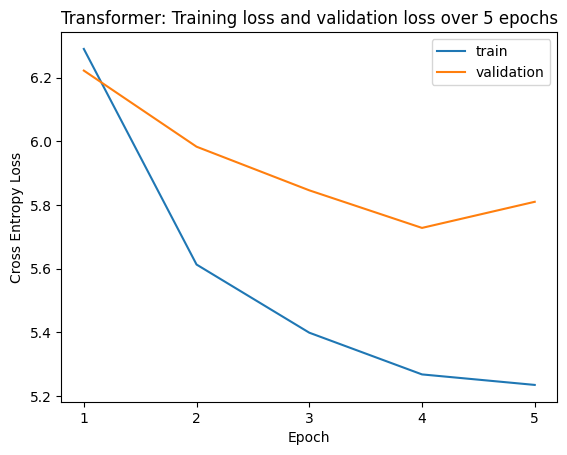

In [ ]:

train_losses = [6.290,5.613,5.399,5.268,5.235]
val_losses = [6.222, 5.983,5.846,5.728,5.810]
x = [i for i in range(1,6)]
plt.plot(x,train_losses,label = 'train')
plt.plot(x,val_losses, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xticks(np.arange(1, 6, step=1))
plt.legend()
plt.title('Transformer: Training loss and validation loss over 5 epochs')

### Inference

In [ ]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
torch.save(transformer.state_dict(), "/content/drive/MyDrive/ML/final_project/200k_5_40_2.pt")

In [ ]:
print(translate(transformer, "according to the journalist"))

 selon les rsultats de la croissance de


- paris is the capital of france
  - le sud est le sud de la rgion de la chine
- according to the news
  - en ligne en ligne
- I can't believe this is happening
  -  les ailleurs , les ailleurs sont les besoins de la mme priode .
- according to the journalist
  - selon les rsultats de la croissance de